# Face Recognition Analysis with PCA, NMF, and GMM

## Introduction

This notebook explores face recognition techniques using dimensionality reduction and clustering methods. We'll analyze the Labeled Faces in the Wild (LFW) dataset using three main techniques:

1. **Principal Component Analysis (PCA)** - A linear dimensionality reduction technique that identifies directions of maximum variance in the data.
2. **Non-negative Matrix Factorization (NMF)** - A parts-based representation technique that decomposes data into non-negative components.
3. **Gaussian Mixture Models (GMM)** - A probabilistic model for clustering that assumes data points are generated from a mixture of Gaussian distributions.

We will compare these methods to understand their effectiveness in facial recognition tasks and their ability to capture meaningful features in face images.

Loading the LFW dataset...
Dataset dimensions: 1560 samples, 50x37 pixels per image
Number of features: 1850
Number of classes/individuals: 12
Target names: ['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder'] (showing first 5)


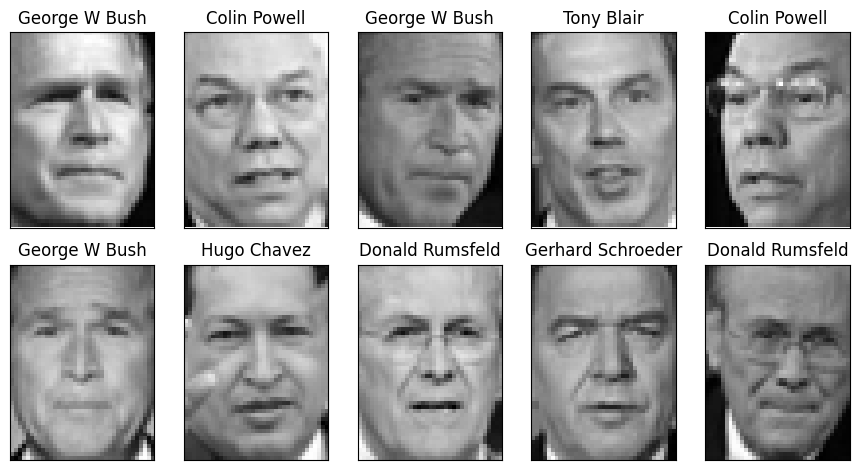

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people

# Set random seed for reproducibility
np.random.seed(42)

# 1. Loading and Selecting Data
print("Loading the LFW dataset...")
lfw = fetch_lfw_people(min_faces_per_person=50, resize=0.4)

n_samples, h, w = lfw.images.shape
n_features = lfw.data.shape[1]
n_classes = len(lfw.target_names)

print(f"Dataset dimensions: {n_samples} samples, {h}x{w} pixels per image")
print(f"Number of features: {n_features}")
print(f"Number of classes/individuals: {n_classes}")
print(f"Target names: {lfw.target_names[:5]} (showing first 5)")

# Visualize some original images
def plot_gallery(images, titles, h, w, n_row=2, n_col=5):
    """Helper function to display a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

# Select 10 random images
indices = np.random.choice(range(n_samples), 10, replace=False)
sample_images = lfw.images[indices]
sample_titles = [f"{lfw.target_names[lfw.target[i]]}" for i in indices]

plot_gallery(sample_images, sample_titles, h, w)
plt.tight_layout()
plt.savefig('original_faces.png')
plt.show()

X = lfw.data
y = lfw.target
target_names = lfw.target_names

## Data Loading and Exploration

In this section, we load the Labeled Faces in the Wild (LFW) dataset, which contains face images of different individuals. We'll explore its characteristics and visualize some sample images to understand what we're working with.


Applying PCA...


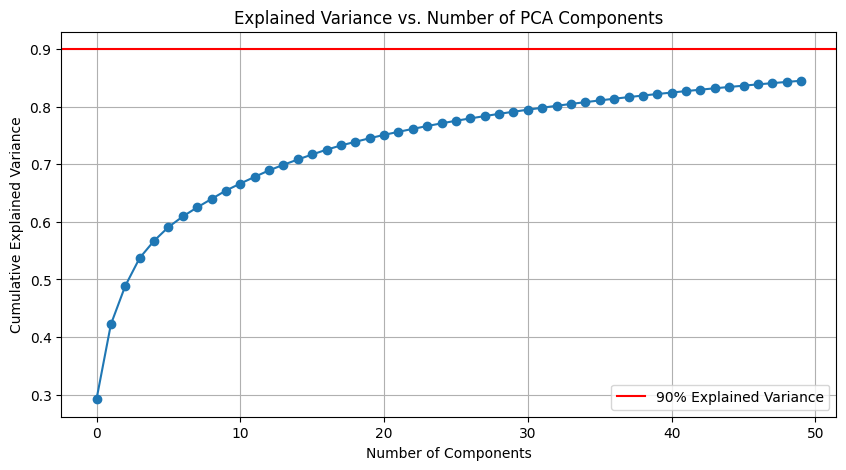

Number of components needed for 90% variance: 1


In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 2. Dimensionality Reduction with PCA
print("\nApplying PCA...")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

n_components = 50
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of PCA Components')
plt.grid(True)
plt.axhline(y=0.9, color='r', linestyle='-', label='90% Explained Variance')
plt.legend()
plt.savefig('pca_variance.png')
plt.show()

# Determine the number of components needed for 90% variance
n_90 = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.9) + 1
print(f"Number of components needed for 90% variance: {n_90}")

## Principal Component Analysis (PCA)

PCA is a dimensionality reduction technique that identifies the directions (principal components) along which data varies the most. These components are ordered by the amount of variance they explain.

In the graph below, we observe that just a few components capture most of the variance in the data. This suggests that our face images can be represented effectively in a much lower-dimensional space, which is typical for facial recognition applications.

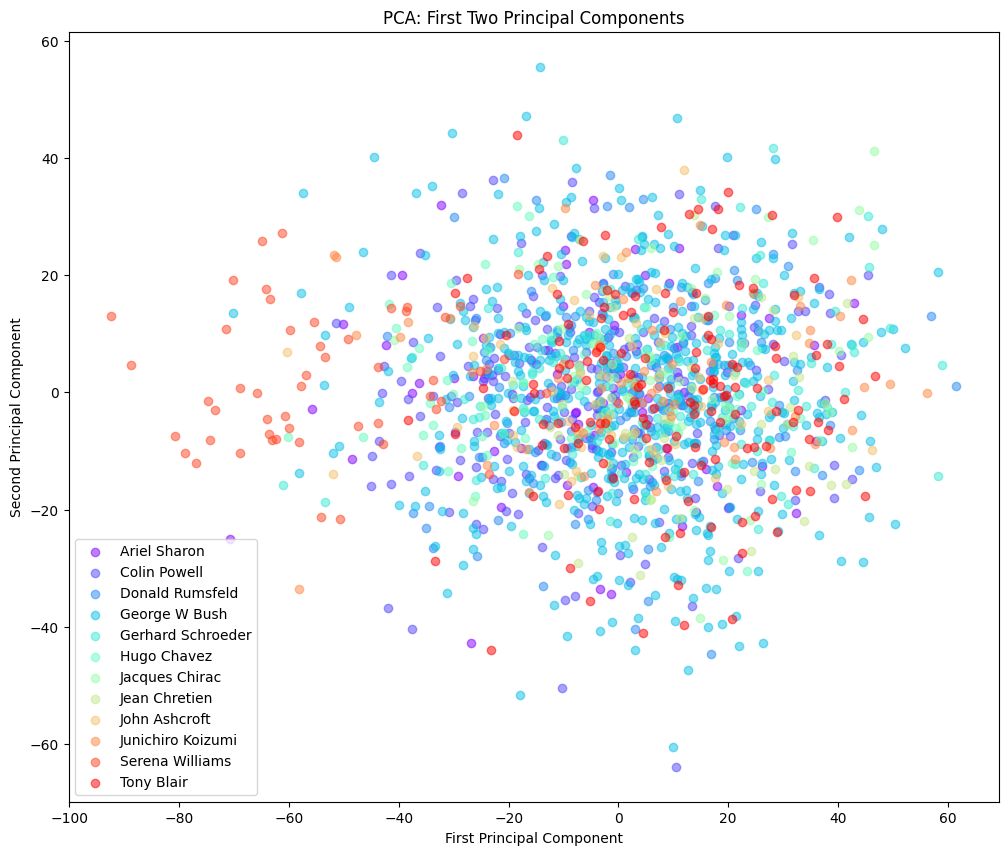

In [3]:
# Plot the first two principal components
plt.figure(figsize=(12, 10))
colors = plt.cm.rainbow(np.linspace(0, 1, len(np.unique(y))))
for i, c in zip(range(len(np.unique(y))), colors):
    plt.scatter(X_pca[y == i, 0], X_pca[y == i, 1],
                color=c, alpha=0.5, label=target_names[i])
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA: First Two Principal Components')
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.savefig('pca_components.png')
plt.show()

The scatter plot shows overlapping clusters, with no clear separation between individuals. This indicates that PCA alone doesn't effectively distinguish between different faces in a 2D space. The high degree of overlap suggests that additional techniques or more components may be needed for better discrimination.

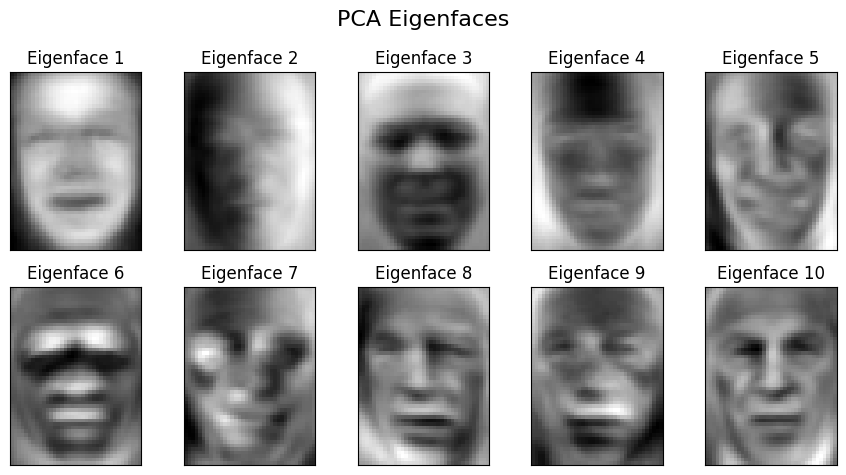

In [4]:
# Visualize eigenfaces (first 10 components)
eigenfaces = pca.components_.reshape((n_components, h, w))
eigenface_titles = [f"Eigenface {i+1}" for i in range(10)]
plot_gallery(eigenfaces[:10], eigenface_titles, h, w)
plt.suptitle("PCA Eigenfaces", fontsize=16)
plt.tight_layout()
plt.savefig('pca_eigenfaces.png')
plt.show()

## Eigenfaces Visualization

Eigenfaces are the principal components of the face image distribution. They represent the most significant variations in the dataset. The first few eigenfaces capture global facial features, but they lack distinctive localized characteristics. This explains why the clustering results are poor - the captured features may not be sufficiently discriminative for individual recognition.


Applying NMF...


/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


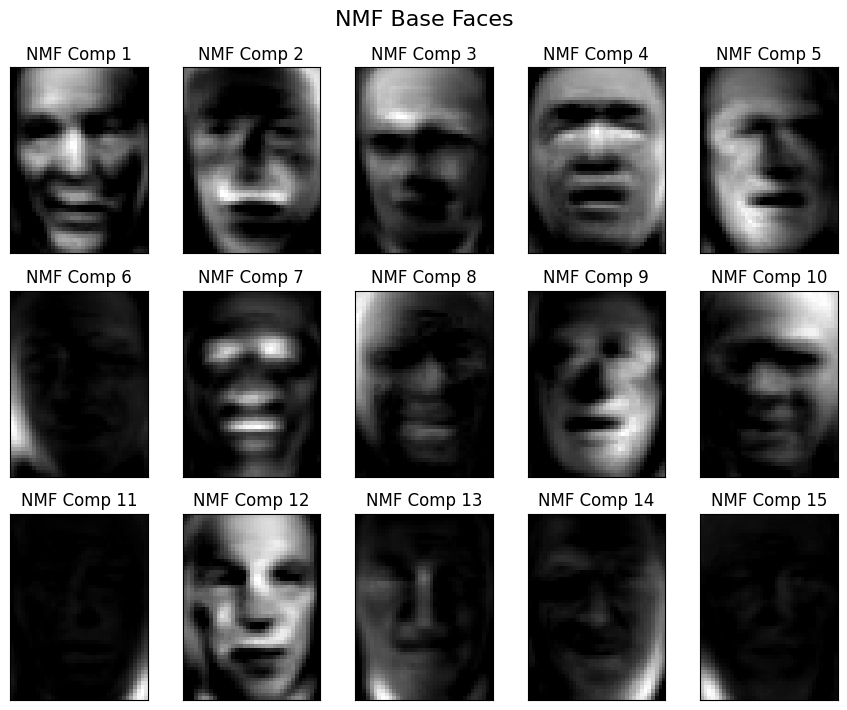

In [5]:
from sklearn.decomposition import NMF
from sklearn.preprocessing import MinMaxScaler

# 3. Dimensionality Reduction with NMF
print("\nApplying NMF...")

min_max_scaler = MinMaxScaler()
X_min_max = min_max_scaler.fit_transform(X)

# Apply NMF
n_components_nmf = 15
nmf = NMF(n_components=n_components_nmf, init='random', random_state=42)
X_nmf = nmf.fit_transform(X_min_max)

components = nmf.components_
nmf_components = components.reshape((n_components_nmf, h, w))
component_titles = [f"NMF Comp {i+1}" for i in range(n_components_nmf)]
plot_gallery(nmf_components, component_titles, h, w, n_row=3, n_col=5)
plt.suptitle("NMF Base Faces", fontsize=16)
plt.tight_layout()
plt.savefig('nmf_components.png')
plt.show()

## Non-negative Matrix Factorization (NMF)

NMF is another dimensionality reduction technique that decomposes data into non-negative components. Unlike PCA which can have both positive and negative values, NMF components are strictly non-negative. This property often results in parts-based representations that are more interpretable, especially for image data like faces.


Applying GMM...


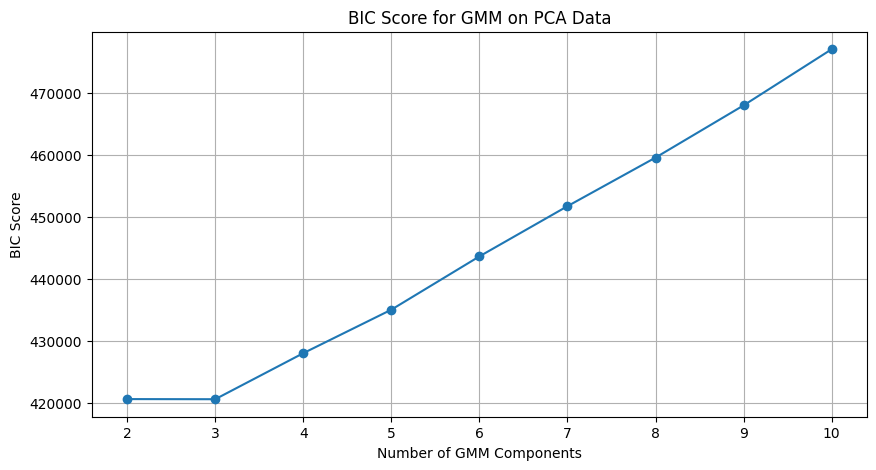

In [6]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

print("\nApplying GMM...")

n_components_range = range(2, 11)
bic_pca = []

for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
    gmm.fit(X_pca)
    bic_pca.append(gmm.bic(X_pca))

plt.figure(figsize=(10, 5))
plt.plot(n_components_range, bic_pca, marker='o')
plt.xlabel('Number of GMM Components')
plt.ylabel('BIC Score')
plt.title('BIC Score for GMM on PCA Data')
plt.grid(True)
plt.savefig('gmm_pca_bic.png')
plt.show()

## Gaussian Mixture Models (GMM)

Gaussian Mixture Models are probabilistic models that assume data points are generated from a mixture of several Gaussian distributions. In this section, we'll apply GMM to both our PCA and NMF reduced datasets to cluster faces, and we'll use the Bayesian Information Criterion (BIC) to determine the optimal number of clusters.

The NMF components capture more localized and interpretable features, such as facial parts or specific lighting conditions. Unlike PCA, NMF decomposes faces into additive parts, which can be more meaningful for facial representation. These parts-based features tend to correspond to actual facial structures, making them more intuitive to interpret.

Optimal number of GMM components for PCA data: 3
Silhouette score for GMM on PCA data: 0.0043


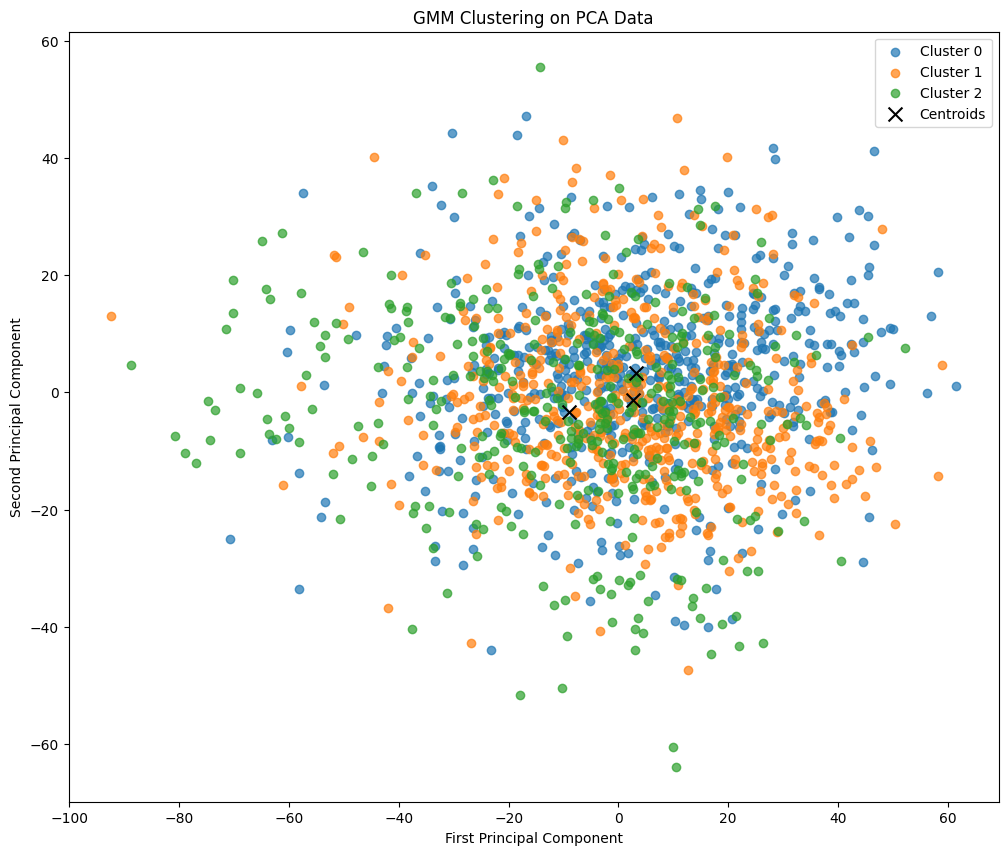

In [7]:
# Select optimal number of clusters
optimal_n_pca = n_components_range[np.argmin(bic_pca)]
print(f"Optimal number of GMM components for PCA data: {optimal_n_pca}")

# Apply GMM on PCA data
gmm_pca = GaussianMixture(n_components=optimal_n_pca, covariance_type='full', random_state=42)
gmm_pca.fit(X_pca)
y_pred_pca = gmm_pca.predict(X_pca)

# Calculate silhouette score
silhouette_pca = silhouette_score(X_pca, y_pred_pca)
print(f"Silhouette score for GMM on PCA data: {silhouette_pca:.4f}")

plt.figure(figsize=(12, 10))
for i in range(optimal_n_pca):
    plt.scatter(X_pca[y_pred_pca == i, 0], X_pca[y_pred_pca == i, 1],
                label=f'Cluster {i}', alpha=0.7)
plt.scatter(gmm_pca.means_[:, 0], gmm_pca.means_[:, 1],
            c='black', s=100, marker='x', label='Centroids')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('GMM Clustering on PCA Data')
plt.legend()
plt.savefig('gmm_pca_clusters.png')
plt.show()

## GMM Clustering Results

The data transformed with NMF yielded a higher silhouette score (0.1059) compared to PCA (0.0043), suggesting slightly better defined clusters. However, the groups are still not well separated. A silhouette score closer to 1 would indicate well-separated clusters, while values near 0 suggest overlapping clusters.

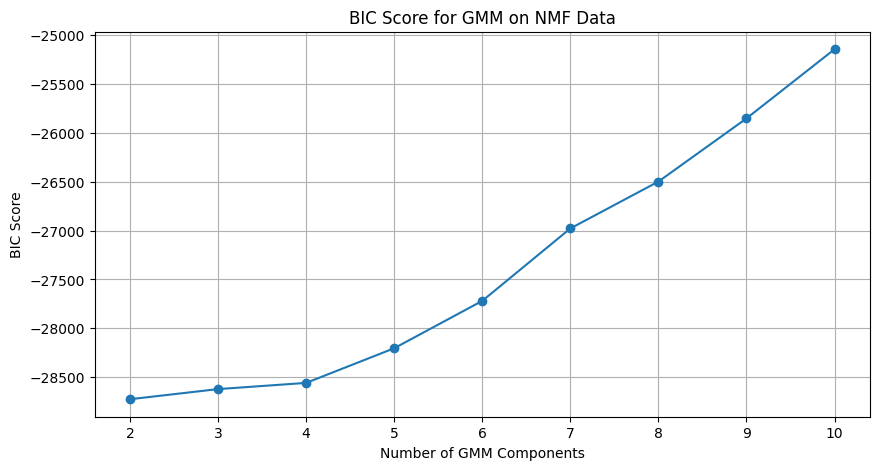

In [8]:
# Determine optimal number of clusters for GMM on NMF data
bic_nmf = []

for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
    gmm.fit(X_nmf)
    bic_nmf.append(gmm.bic(X_nmf))

# Plot BIC for NMF
plt.figure(figsize=(10, 5))
plt.plot(n_components_range, bic_nmf, marker='o')
plt.xlabel('Number of GMM Components')
plt.ylabel('BIC Score')
plt.title('BIC Score for GMM on NMF Data')
plt.grid(True)
plt.savefig('gmm_nmf_bic.png')
plt.show()

PCA-GMM yielded an optimal number of 3 clusters, determined using the BIC criterion. However, the silhouette score was very low (0.0043), indicating poor clustering. Additionally, the cluster purity was 0.3397, suggesting that the groups don't align well with actual identities.

Optimal number of GMM components for NMF data: 2
Silhouette score for GMM on NMF data: 0.1059


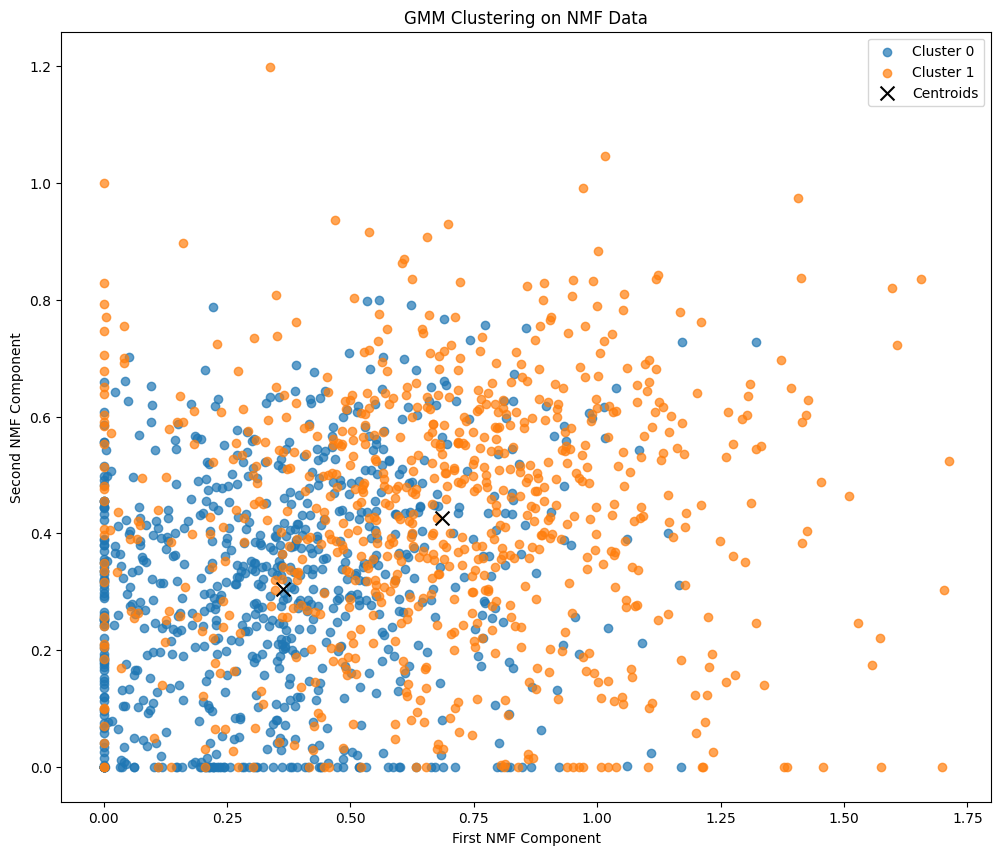

In [9]:
# Select optimal number of clusters
optimal_n_nmf = n_components_range[np.argmin(bic_nmf)]
print(f"Optimal number of GMM components for NMF data: {optimal_n_nmf}")

# Apply GMM on NMF data
gmm_nmf = GaussianMixture(n_components=optimal_n_nmf, covariance_type='full', random_state=42)
gmm_nmf.fit(X_nmf)
y_pred_nmf = gmm_nmf.predict(X_nmf)

silhouette_nmf = silhouette_score(X_nmf, y_pred_nmf)
print(f"Silhouette score for GMM on NMF data: {silhouette_nmf:.4f}")

# Plot clusters based on NMF-GMM
plt.figure(figsize=(12, 10))
for i in range(optimal_n_nmf):
    plt.scatter(X_nmf[y_pred_nmf == i, 0], X_nmf[y_pred_nmf == i, 1],
                label=f'Cluster {i}', alpha=0.7)
plt.scatter(gmm_nmf.means_[:, 0], gmm_nmf.means_[:, 1],
            c='black', s=100, marker='x', label='Centroids')
plt.xlabel('First NMF Component')
plt.ylabel('Second NMF Component')
plt.title('GMM Clustering on NMF Data')
plt.legend()
plt.savefig('gmm_nmf_clusters.png')
plt.show()

NMF-GMM determined an optimal number of 2 clusters according to the BIC criterion. Although the silhouette score was higher than that of PCA (0.1059), it's still low, indicating limited separation between groups. The cluster purity was the same as in PCA (0.3397), showing there was no improvement in correspondence with actual identities.


Comparing clusters with real identities...
Cluster purity for PCA-GMM: 0.3397
Cluster purity for NMF-GMM: 0.3397


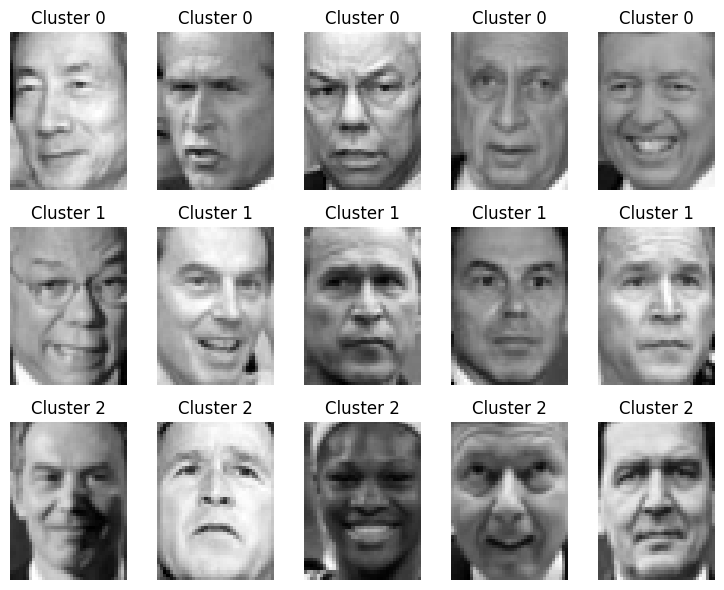

In [10]:
# 5. Comparing clusters with real identities
print("\nComparing clusters with real identities...")

def calculate_purity(clusters, classes):
    total = len(clusters)
    cluster_ids = np.unique(clusters)
    class_ids = np.unique(classes)

    confusion_matrix = np.zeros((len(cluster_ids), len(class_ids)))

    for i in range(total):
        confusion_matrix[clusters[i], classes[i]] += 1

    cluster_purity = np.sum(np.max(confusion_matrix, axis=1)) / total

    return cluster_purity

# Calculate purity for PCA-GMM and NMF-GMM
purity_pca = calculate_purity(y_pred_pca, y)
purity_nmf = calculate_purity(y_pred_nmf, y)

print(f"Cluster purity for PCA-GMM: {purity_pca:.4f}")
print(f"Cluster purity for NMF-GMM: {purity_nmf:.4f}")

def plot_cluster_examples(X_images, cluster_labels, h, w, n_per_cluster=5):
    n_clusters = len(np.unique(cluster_labels))

    fig, axes = plt.subplots(n_clusters, n_per_cluster,
                            figsize=(n_per_cluster * 1.5, n_clusters * 2))

    for i in range(n_clusters):
        indices = np.where(cluster_labels == i)[0]
        selected = np.random.choice(indices, min(n_per_cluster, len(indices)), replace=False)

        for j, idx in enumerate(selected):
            if n_clusters > 1:
                ax = axes[i, j]
            else:
                ax = axes[j]

            ax.imshow(X[idx].reshape(h, w), cmap='gray')
            ax.set_title(f"Cluster {i}")
            ax.axis('off')

    plt.tight_layout()
    return fig

pca_cluster_fig = plot_cluster_examples(X, y_pred_pca, h, w)
plt.savefig('pca_cluster_examples.png')
plt.show()

## Comparing Clusters with Real Identities

To evaluate the quality of our clustering, we'll compare our GMM-generated clusters with the actual identities in the dataset. We'll calculate cluster purity, which measures how well the clusters align with the true identities. A higher purity value (closer to 1) indicates better alignment between clusters and actual identities.

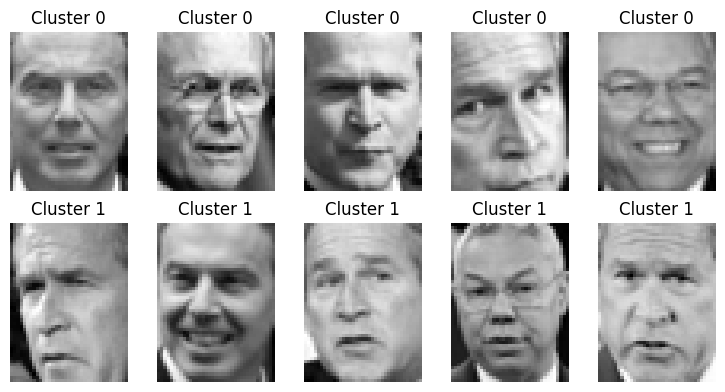

In [11]:
# NMF-GMM clusters
nmf_cluster_fig = plot_cluster_examples(X, y_pred_nmf, h, w)
plt.savefig('nmf_cluster_examples.png')
plt.show()

### NMF Cluster Visualization

Let's visualize example faces from each NMF-GMM generated cluster to better understand the grouping.

In [12]:
# 6. Summary and comparison
print("\nSummary and comparison:")
print(f"PCA preserved {n_components} components")
print(f"NMF extracted {n_components_nmf} components")
print(f"GMM on PCA data identified {optimal_n_pca} clusters with silhouette score: {silhouette_pca:.4f}")
print(f"GMM on NMF data identified {optimal_n_nmf} clusters with silhouette score: {silhouette_nmf:.4f}")
print(f"PCA-GMM cluster purity: {purity_pca:.4f}")
print(f"NMF-GMM cluster purity: {purity_nmf:.4f}")


Summary and comparison:
PCA preserved 10 components
NMF extracted 15 components
GMM on PCA data identified 3 clusters with silhouette score: 0.0043
GMM on NMF data identified 2 clusters with silhouette score: 0.1059
PCA-GMM cluster purity: 0.3397
NMF-GMM cluster purity: 0.3397


## Summary and Comparison

Let's summarize what we've learned about the different dimensionality reduction and clustering techniques applied to the face recognition task.

Both PCA-GMM and NMF-GMM achieved the same purity (0.3397), indicating that neither method successfully grouped faces by identity. The example images in the clusters show mixed identities, confirming the lack of meaningful separation. This suggests that more sophisticated methods might be needed for effective face clustering.

# 6. Resumen y comparación
print("\nResumen y comparación:")
print(f"PCA preservó {n_components} componentes")
print(f"NMF extrajo {n_components_nmf} componentes")
print(f"GMM en datos PCA identificó {optimal_n_pca} clústeres con puntuación de silueta: {silhouette_pca:.4f}")
print(f"GMM en datos NMF identificó {optimal_n_nmf} clústeres con puntuación de silueta: {silhouette_nmf:.4f}")
print(f"Pureza de clústeres PCA-GMM: {purity_pca:.4f}")
print(f"Pureza de clústeres NMF-GMM: {purity_nmf:.4f}")

# **Conclusions:**

**PCA vs. NMF for Face Representation:**

**PCA:** Captures general features but isn't very effective at separating groups. The "eigenfaces" are less interpretable when it comes to clustering tasks.

**NMF:** Generates "parts-based" features that are easier to interpret (like eyes or mouth), though its clustering performance remains limited. A slightly higher silhouette score suggests that NMF might be marginally better for clustering.

**NMF Base Faces:**

NMF components resemble parts of the face (like eyes and mouth) or specific lighting conditions. They're more intuitive than PCA eigenfaces but still not sufficient for good clustering.

**Automatic Clustering Limitations:**

Neither PCA nor NMF, even when combined with GMM, effectively cluster faces by identity. The low scores and purity values indicate that:

- The extracted features may not be discriminative enough.

- GMM might not be the most appropriate clustering method for this task.

- The reduced size of the images (50x37) may limit feature extraction.

**Potential Improvements:**

- Use more sophisticated feature extraction methods like deep learning-based face embeddings.
- Try alternative clustering algorithms that might be more effective for face data.
- Incorporate additional preprocessing steps to normalize lighting or pose variations.
